In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from models import make_model
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


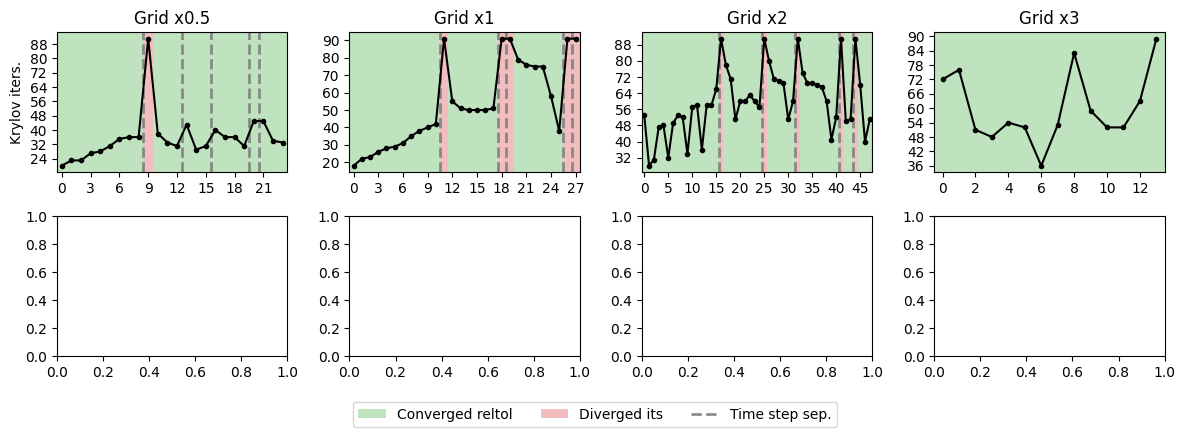

In [2]:
grid_refinement = [
    0.5,
    1,
    2,
    3,
    # 4,
    # 5,
    # 6,
    # 10,
    # 33,
]

data = {}
names = {}
for i, g in enumerate(grid_refinement):
    data[i] = load_data(f"../stats/stats_geo0.3x{g}_sol{2}_ph{1}_bb{2}_fr{1}.json")
    names[i] = f"Grid x{g}"


shape = [2, 4]
figsize = (12, 4)


def render_element(entry: list[TimeStepStats]):
    color_converged_reason(entry)
    # color_sticking_sliding_open(entry)

    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    set_integer_ticks("vertical")
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

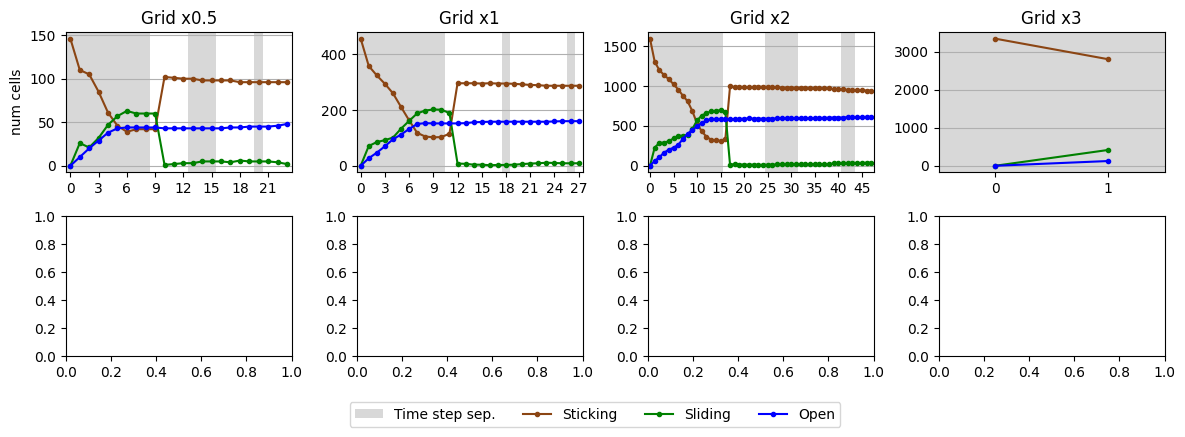

In [5]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    st, sl, op = get_num_sticking_sliding_open(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [6]:
from collections import defaultdict
import pandas as pd

table = defaultdict(lambda: [])

NDIGITS = 2

grid_refinement = [
    0.5,
    1,
    2,
    # 3,
    # 4,
    # 5,
    # 6,
    # 10,
]

for g in grid_refinement:
    stats_name = f"stats_geo0.3x{g}_sol2_ph1_bb2_fr1.json"
    entry = load_data(f"../stats/{stats_name}")
    dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
    total_dofs = dofs_info["total dofs"]
    table["tmp"] = "-"
    table["Total DoFs"].append(int(total_dofs))
    table["GMRES iters."].append(int(np.mean(get_gmres_iterations(entry))))
    table["Newton iters."].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))

    converged_reason = get_petsc_converged_reason(entry)
    # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table).T[1:]
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = "Total DoFs"
table

Total DoFs,6461,29002,174668
GMRES iters.,35,34,59
Newton iters.,4.0,4.67,8.0


In [11]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mandel_runscript_3 import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 0.3,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.0, Dt: 1.75 (days)
sticking: 456, sliding: 0, open: 0


In [15]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 2
)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)

model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.ad_time_step.set_value(dt)
model.linear_system = mat, rhs
model.bmat.mat = mat


Sim time: 0.0, Dt: 1.75 (days)
sticking: 324, sliding: 85, open: 47


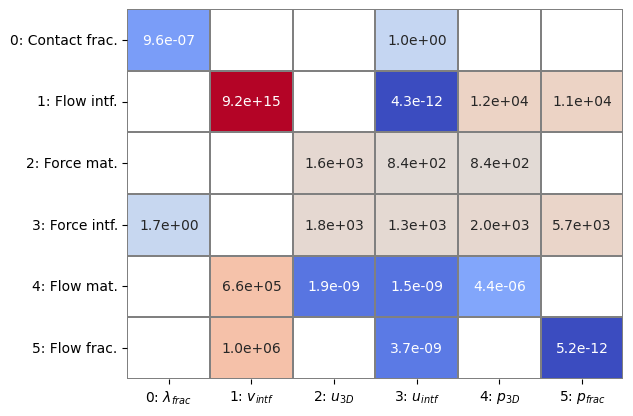

In [13]:
J = model.bmat[:]
J.plot_max()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Construction took: 2.85
Solve  took: 2.12
True residual: 9.342836829374655e-09
PETSc Converged Reason: 2


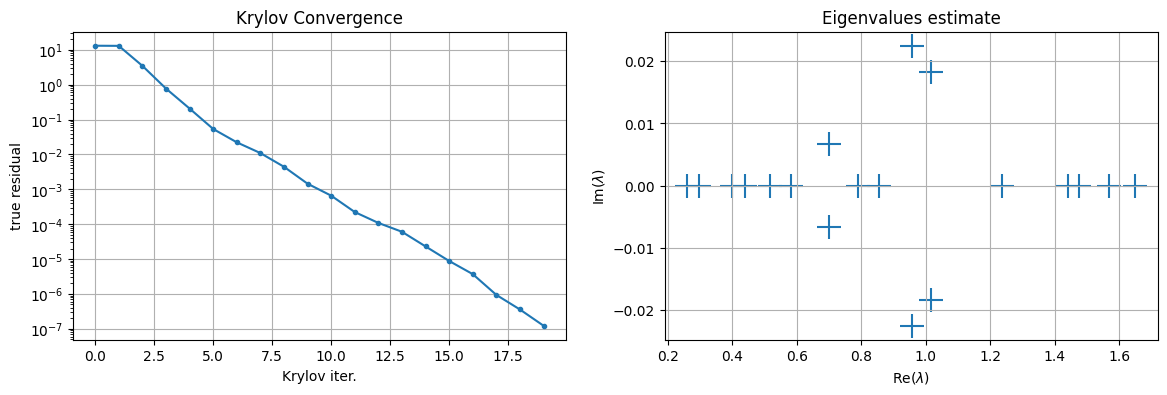

In [49]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat, factor_levels=0),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat
                    * 1,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

In [29]:
[sd.cell_volumes for sd in model.mdg.subdomains(dim=2)]
model.specific_volume(model.mdg.subdomains(dim=2)).value(model.equation_system)

array([0.00017515, 0.00017516, 0.00191817, 0.00134873, 0.00188763,
       0.00136118, 0.00017515, 0.00017515, 0.00029878, 0.00017569,
       0.0001761 , 0.00031011, 0.00017545, 0.00017545, 0.0001755 ,
       0.00017534, 0.00017519, 0.00017525, 0.00017526, 0.00017528,
       0.00027224, 0.00026515, 0.00017618, 0.00017571, 0.00017552,
       0.00017544, 0.00017533, 0.00017548, 0.00017519, 0.00017525,
       0.00017526, 0.00017528, 0.0001752 , 0.00017521, 0.00017522,
       0.00017525, 0.00017523, 0.00017527, 0.00017521, 0.00017526,
       0.00017522, 0.00237312, 0.00214906, 0.0026128 , 0.00249133,
       0.00260739, 0.00264384, 0.00236521, 0.00253191, 0.00218421,
       0.00039892, 0.00125945, 0.00017564, 0.00042712, 0.00021528,
       0.00040173, 0.00017601, 0.00047025, 0.00024399, 0.0019872 ,
       0.00022905, 0.00043647, 0.00025885, 0.00209483, 0.00024374,
       0.0003622 , 0.00024514, 0.00214858, 0.00024803, 0.00036567,
       0.00017602, 0.00017578, 0.00017563, 0.0001757 , 0.00017

In [17]:
J.shape

(29002, 29002)

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            # lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[2, 3],
            # solve=lambda bmat: PetscAMGMechanics(
            #     mat=bmat[[2, 3]].mat,
            #     dim=model.nd,
            #     null_space=build_mechanics_near_null_space(model),
            # ),
            invertor=lambda bmat: inv_block_diag(bmat[[2,3]].mat, nd=model.nd, lump=False),
            complement=FieldSplitScheme(
                groups=[0]
            )
            # groups=[0],
            # complement=FieldSplitScheme(
            #     groups=[2,3],
            # solve=lambda bmat: PetscAMGMechanics(
            #     mat=bmat[[2]].mat,
            #     dim=model.nd,
            #     null_space=build_mechanics_near_null_space(model, include_intf=False),
            # ),
            # groups=[2, 3],
            # solve=lambda bmat: BlockJacobi(
            #     bmat,
            #     solve_A=inv(bmat[[2]].mat),
            #     solve_B=inv(bmat[[3]].mat),
            #     # solve_A=PetscAMGMechanics(
            #     #     dim=model.nd,
            #     #     mat=bmat[[3]].mat,
            #     #     null_space=build_mechanics_near_null_space(
            #     #         model, include_intf=False
            #     #     ),
            #     # ),
            #     # solve_B=PetscAMGMechanics(
            #     #     dim=model.nd,
            #     #     mat=bmat[[4]].mat,
            #     #     null_space=build_mechanics_near_null_space(model, include_sd=False),
            #     # ),
            #     groups_0=[2],
            #     groups_1=[3],
            # ),
            # ),
        ),
    ),
)

Solve  took: 0.02
True residual: 9.43288359848327e-09
PETSc Converged Reason: 2
Error in callback <function flush_figures at 0x79ec87af68e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


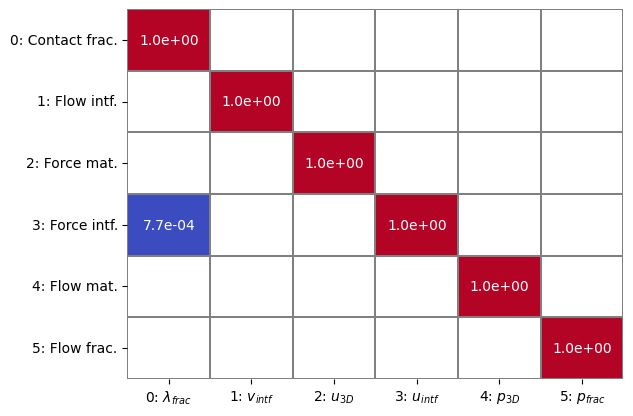

In [ ]:
def make_S(bmat: BlockMatrixStorage, elim: list[int], keep: list[int]):
    stab = bmat[keep, keep].empty_container()
    stab.mat = -bmat[keep, elim].mat @ inv(bmat[elim, elim].mat) @ bmat[elim, keep].mat
    S = bmat[keep, keep].copy()
    S.mat += stab.mat
    return S, stab

Qr = model.Qright(contact_group=0, u_intf_group=3)
Qr.plot_max()

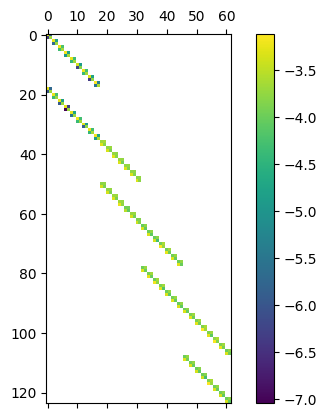

In [ ]:
Qr[3,0].matshow()

In [ ]:

# Ql = model.Qleft(contact_group=0, u_intf_group=3)

# Qr[3,0] = Qr[3,0].mat * 1e1

Jq = J[:].empty_container()
Jq.mat = J.mat @ Qr.mat

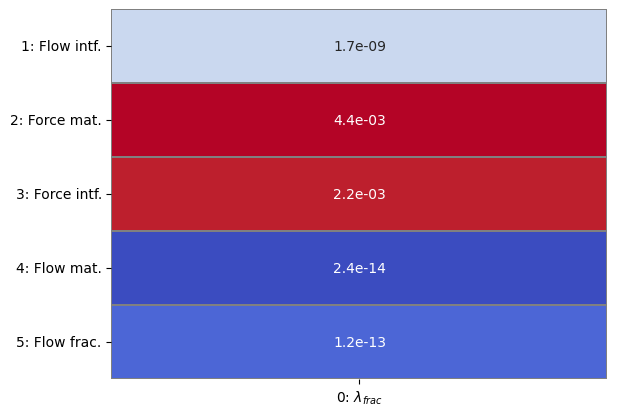

In [ ]:
e = [0]
k = [1,2,3,4,5]
Jq[k, e].plot_max()

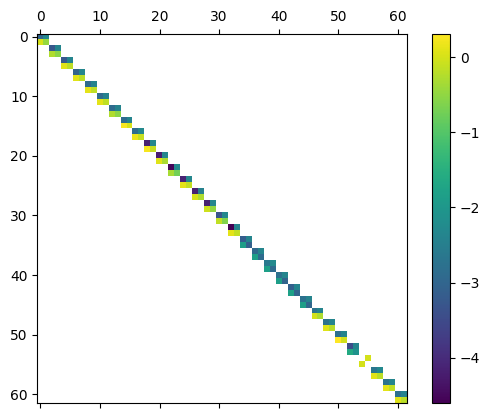

In [ ]:
Jq[e,e].matshow()

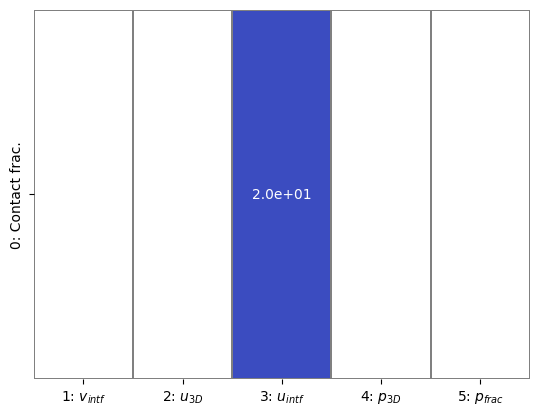

In [ ]:
Jq[e,k].plot_max()

J^Q_00

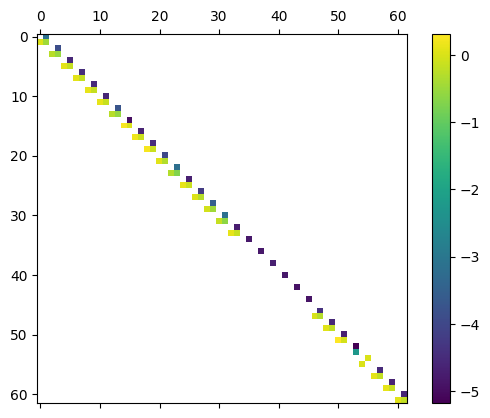

In [ ]:
J[[0]].matshow()

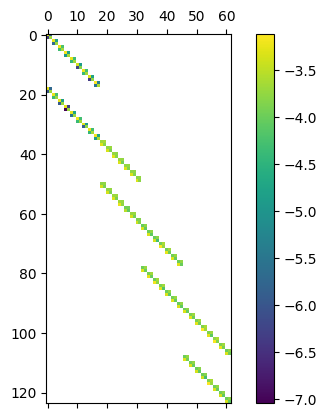

In [ ]:
qr = Qr[3,0]
qr.matshow()

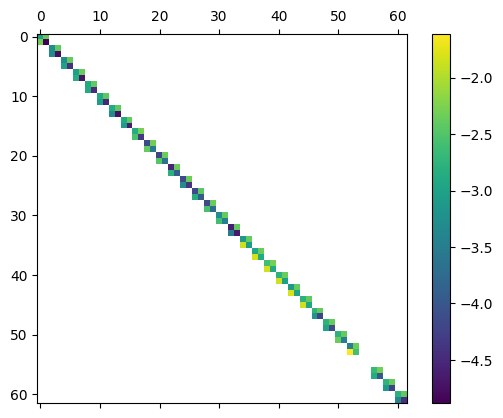

In [ ]:
tmp = J[0,0].empty_container()
tmp.mat = J[0,3].mat @ qr.mat
tmp.matshow()

 J_^Q_30

In [ ]:
st, sl, op = model.sticking_sliding_open()
st = np.repeat(st, model.nd)
sl = np.repeat(sl, model.nd)
op = np.repeat(op, model.nd)

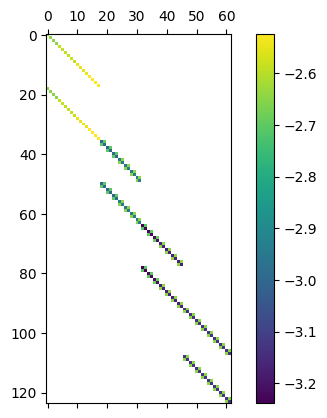

In [ ]:
J[3,0].matshow()

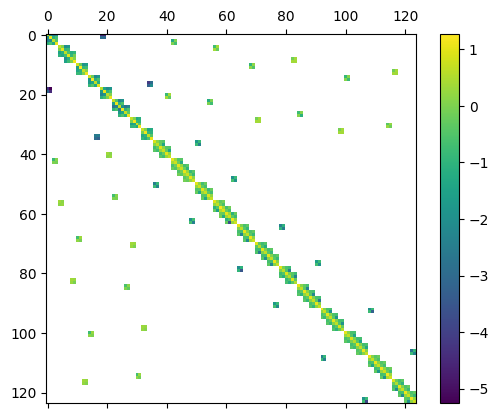

In [ ]:
J[3,3].matshow()

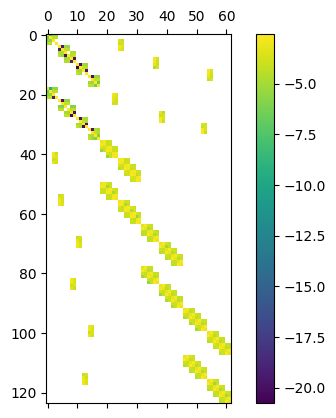

In [ ]:
tmp = J[3,0].empty_container()
tmp.mat = J[3,3].mat @ qr.mat
tmp.matshow()

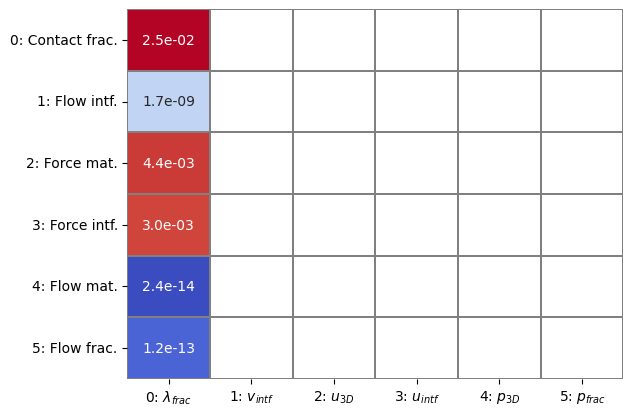

In [ ]:
tmp = J.empty_container()[:]
tmp.mat = Jq.mat - J.mat
tmp.plot_max()

In [ ]:
S1, stab1 = make_S(Jq, [0], [1,2,3,4,5])

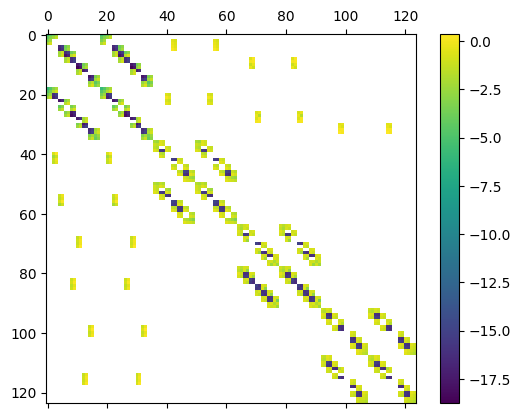

In [ ]:
stab1[[3]].matshow()

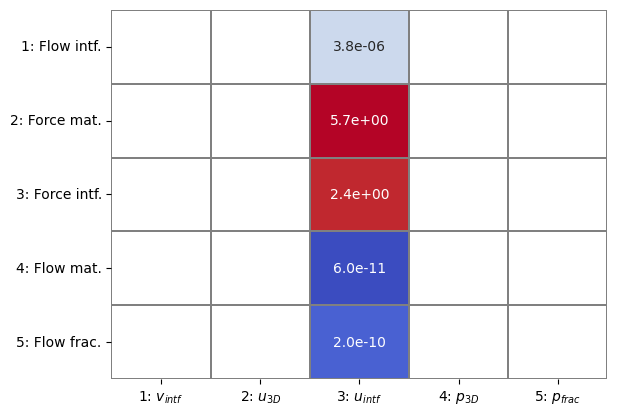

In [ ]:
stab1.plot_max()

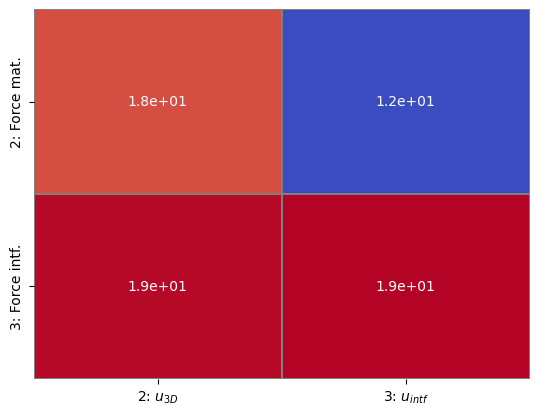

In [ ]:
Jq[[2,3]].plot_max()

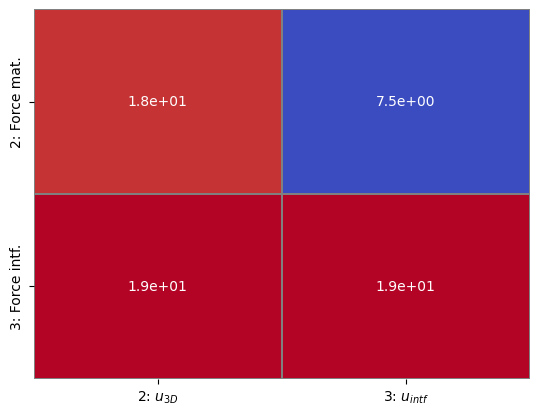

In [ ]:
S1[[2,3]].plot_max()

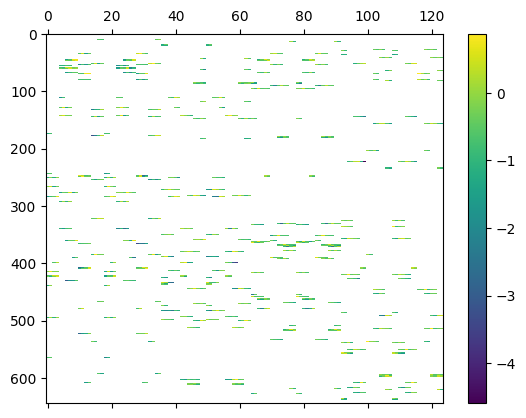

In [ ]:
S1[2,3].matshow(aspect='auto')

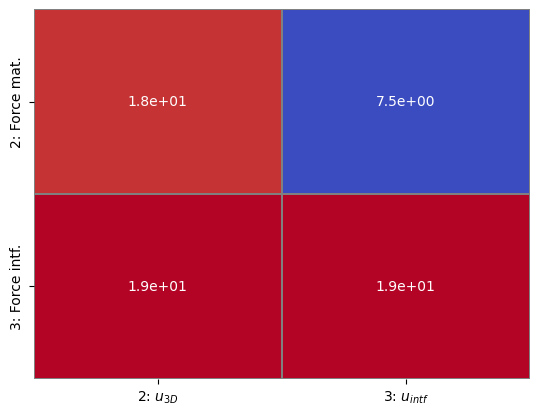

In [ ]:
S1[[2,3]].plot_max()
# S1.set_zeros(4,5)

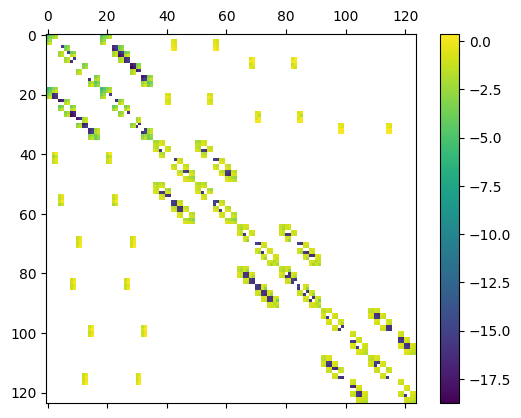

In [ ]:
tmp = S1[[2,3]].empty_container()
tmp.mat = S1[[2,3]].mat - J[[2,3]].mat
tmp[[3]].matshow()

In [ ]:
tmp = Jq[[2,3]].empty_container()
tmp.mat = Jq[[2,3]].mat + stab1[[2,3]].mat# * 1e3
abs(tmp.mat).max()

18.961314867113895

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    Jq,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        preconditioner=FieldSplitScheme(
            groups=[2, 3],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2, 3]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model),
            ),
        ),
    ),
)

Solve  took: 0.01
True residual: 5.295496774455438e-09
PETSc Converged Reason: 2
Error in callback <function flush_figures at 0x71689530a8e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Reorder contact

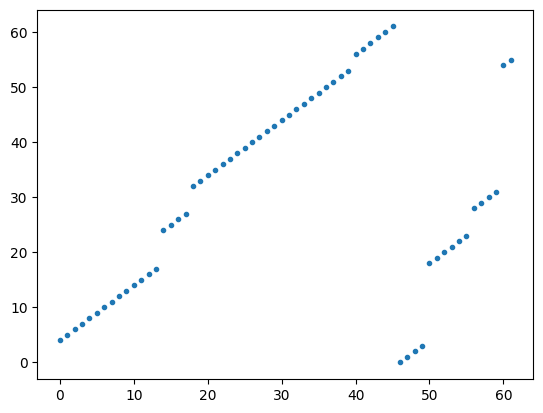

In [ ]:
st, sl, op = model.sticking_sliding_open()
st = np.repeat(st, model.nd)
sl = np.repeat(sl, model.nd)
op = np.repeat(op, model.nd)
others = np.arange(rhs.size)[len(st):]
st = np.where(st)[0].astype(int)
sl = np.where(sl)[0].astype(int)
op = np.where(op)[0].astype(int)
perm = np.concatenate([st, sl, op])
plt.plot(perm, linewidth=0, marker='.')

IndexError: index -1 is out of bounds for axis 0 with size 0

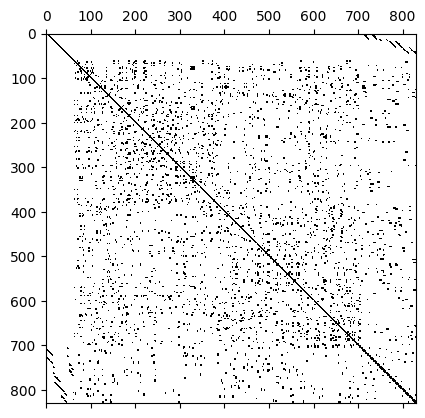

In [ ]:
tmp = J[[0,2,3]]

dofs_col_2 = [tmp.local_dofs_col[block_idx] for block_idx in tmp.groups_to_blocks_col[2]]
dofs_row_2 = [tmp.local_dofs_row[block_idx] for block_idx in tmp.groups_to_blocks_row[2]]
dofs_col_3 = [tmp.local_dofs_col[block_idx] for block_idx in tmp.groups_to_blocks_col[3]]
dofs_row_3 = [tmp.local_dofs_row[block_idx] for block_idx in tmp.groups_to_blocks_row[3]]

Jalt = BlockMatrixStorage(
    mat=tmp.mat,
    global_dofs_col=[st, sl, op] + dofs_col_2 + dofs_col_3,
    global_dofs_row=[st, sl, op] + dofs_row_2 + dofs_row_3,
    groups_to_blocks_col=[[0], [1], [2], [3], [4,5,6,7]],
    groups_to_blocks_row=[[0], [1], [2], [3], [4,5,6,7]],
    group_names_row=["st", "sl", "op", 'umat', 'uintf'],
    group_names_col=["st", "sl", "op", 'umat', 'uintf'],
)[:]
Jalt.color_spy()

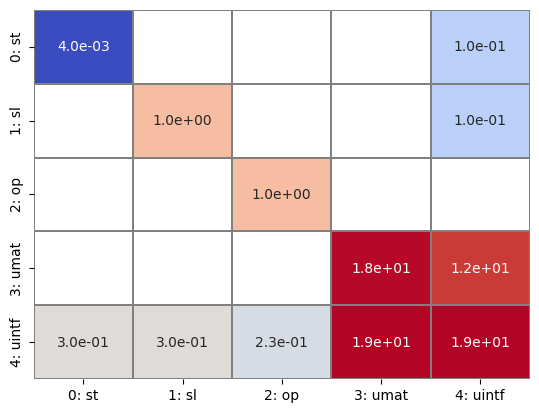

In [ ]:
Jalt.plot_max()

Only sticking block is singular

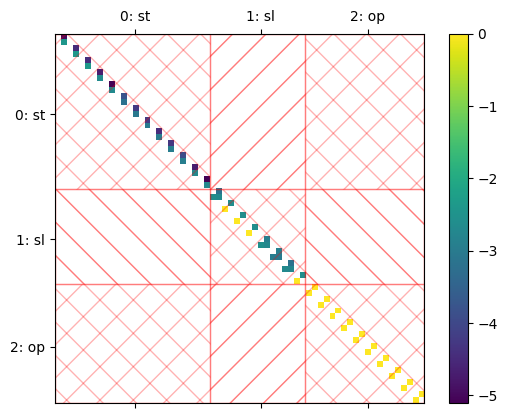

In [ ]:
Jalt[[0,1,2]].matshow_blocks()

Solve  took: 0.01
True residual: 8.734497450588866e-10
PETSc Converged Reason: 3


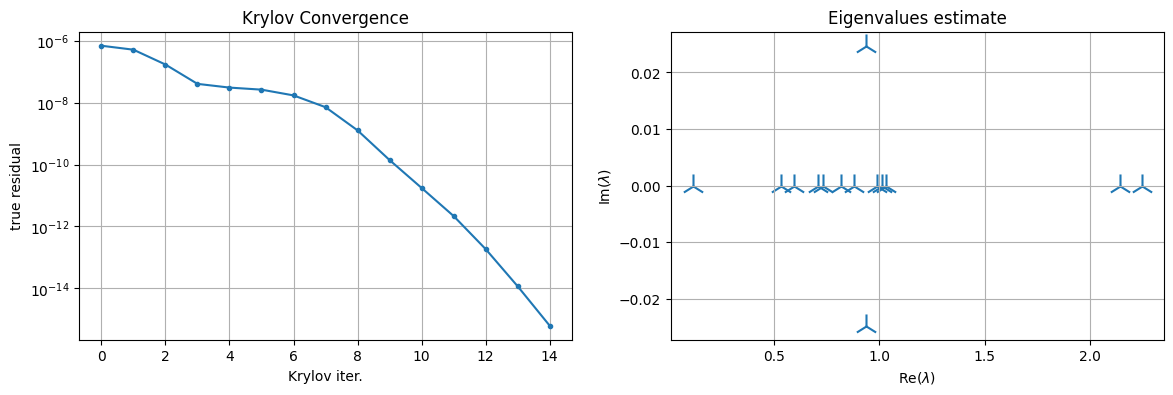

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

def Qright(bmat: BlockMatrixStorage, contact_group: int, u_intf_group: int, nd: int) -> BlockMatrixStorage:
    Qright = bmat.empty_container()[:]
    J55 = bmat[u_intf_group, u_intf_group].mat
    J55_inv = inv_block_diag(J55, nd=nd, lump=False)
    Qright.mat = csr_ones(Qright.shape[0])
    J54 = bmat[u_intf_group, contact_group].mat
    tmp = -J55_inv @ J54
    Qright[u_intf_group, contact_group] = tmp# * 1e-3
    return Qright

solve_petsc_3(
    Jalt,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            # lambda bmat: Qright(bmat, contact_group=[0], u_intf_group=4, nd=model.nd)
        ],
        preconditioner=FieldSplitScheme(
            groups=[1, 2],
            solve=lambda bmat: inv_block_diag(mat=bmat[[1, 2]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[3, 4],
                solve=lambda bmat: PetscAMGMechanics(
                    mat=bmat[[3, 4]].mat,
                    dim=model.nd,
                    null_space=build_mechanics_near_null_space(model),
                ),
            ),
        ),
    ),
)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


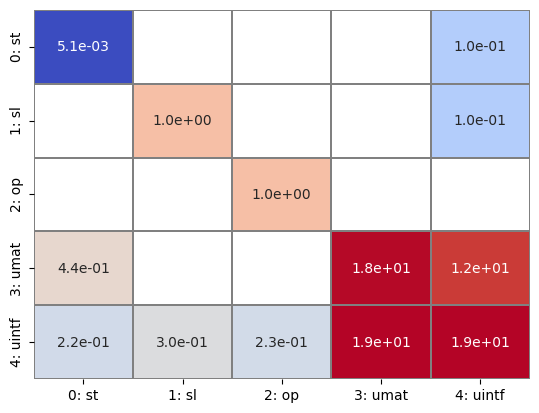

In [ ]:
JaltQ = Jalt.empty_container()
JaltQ.mat = Jalt.mat @ Qright(Jalt, [0], 4, nd=model.nd).mat
JaltQ.plot_max()

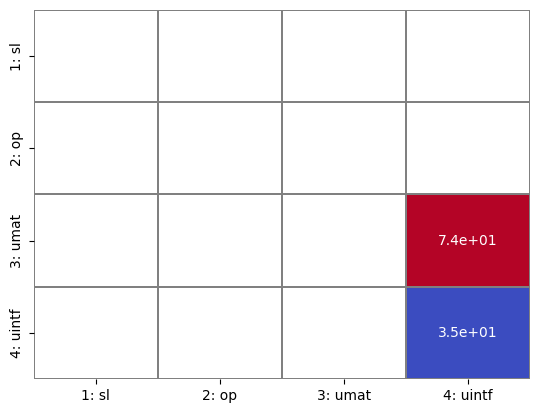

In [ ]:
k = [1,2,3,4]
Stab = JaltQ[k].empty_container()
Stab.mat = -JaltQ[k,0].mat @ inv(JaltQ[0,0].mat) @ JaltQ[0,k].mat
Stab.plot_max()

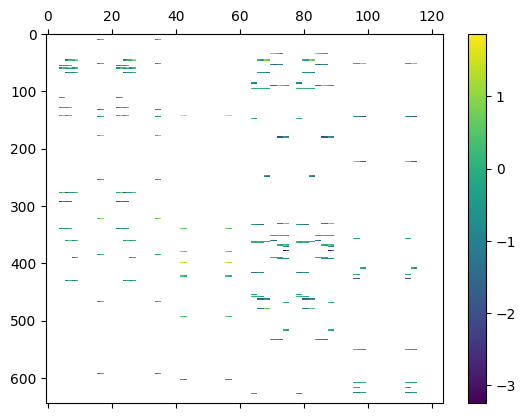

In [ ]:
Stab[3,4].matshow(aspect='auto')

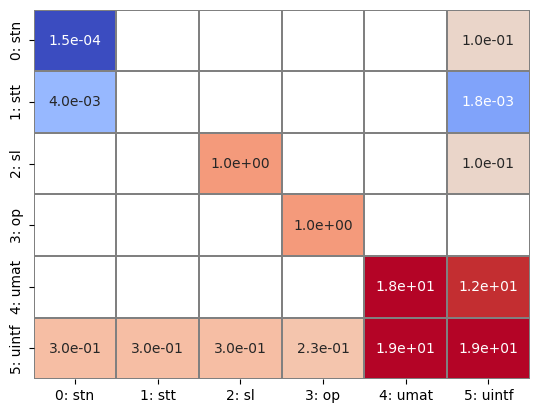

In [ ]:
tmp = J[[0,2,3]]

dofs_col_2 = [tmp.local_dofs_col[block_idx] for block_idx in tmp.groups_to_blocks_col[2]]
dofs_row_2 = [tmp.local_dofs_row[block_idx] for block_idx in tmp.groups_to_blocks_row[2]]
dofs_col_3 = [tmp.local_dofs_col[block_idx] for block_idx in tmp.groups_to_blocks_col[3]]
dofs_row_3 = [tmp.local_dofs_row[block_idx] for block_idx in tmp.groups_to_blocks_row[3]]
st0 = st[::2]
st1 = st[1::2]

Jalt2 = BlockMatrixStorage(
    mat=tmp.mat,
    global_dofs_col=[st0, st1, sl, op] + dofs_col_2 + dofs_col_3,
    global_dofs_row=[st0, st1, sl, op] + dofs_row_2 + dofs_row_3,
    groups_to_blocks_col=[[1], [0], [2], [3], [4], [5,6,7,8]],
    groups_to_blocks_row=[[0], [1], [2], [3], [4], [5,6,7,8]],
    group_names_row=["stn", 'stt', "sl", "op", 'umat', 'uintf'],
    group_names_col=["stn", 'stt', "sl", "op", 'umat', 'uintf'],
)[:]
Jalt2.plot_max()

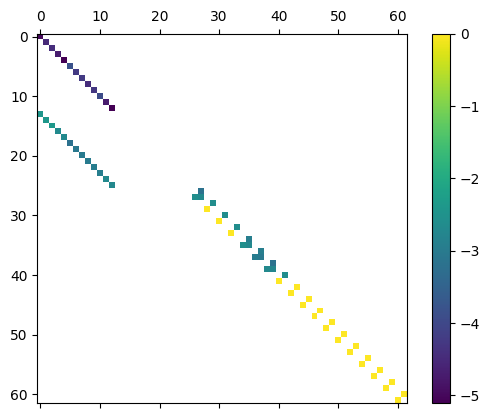

In [ ]:
Jalt2[[0,1,2,3]].matshow()

Solve  took: 0.02
True residual: 1.9915527073721445e-09
PETSc Converged Reason: 2


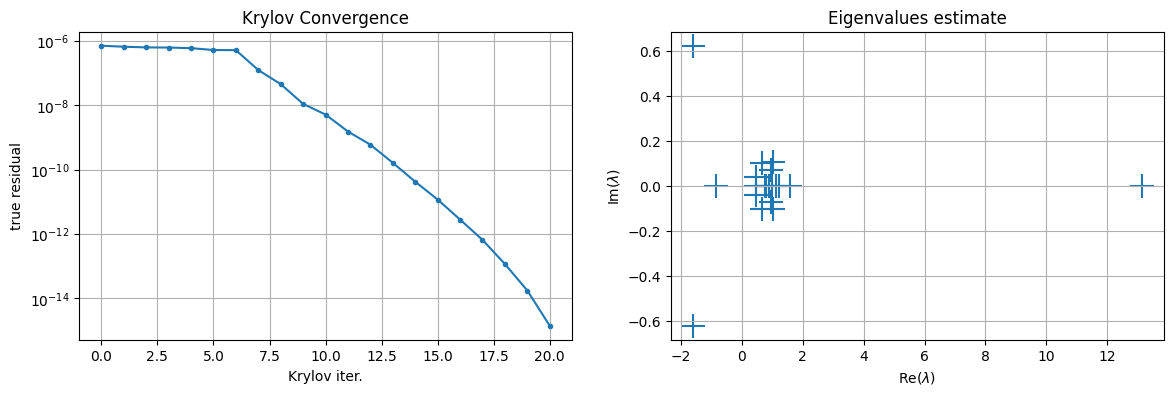

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

def Qright(bmat: BlockMatrixStorage, contact_group: int, u_intf_group: int, nd: int) -> BlockMatrixStorage:
    Qright = bmat.empty_container()[:]
    J55 = bmat[u_intf_group, u_intf_group].mat
    J55_inv = inv_block_diag(J55, nd=nd, lump=False)
    Qright.mat = csr_ones(Qright.shape[0])
    J54 = bmat[u_intf_group, contact_group].mat
    tmp = -J55_inv @ J54
    Qright[u_intf_group, contact_group] = tmp# * 1e-3
    return Qright

solve_petsc_3(
    Jalt2,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            # lambda bmat: Qright(bmat, contact_group=[0], u_intf_group=4, nd=model.nd)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0, 2, 3],
            complement=FieldSplitScheme(
                groups=[4, 5],
                solve=lambda bmat: PetscAMGMechanics(
                    mat=bmat[[4, 5]].mat,
                    dim=model.nd,
                    null_space=build_mechanics_near_null_space(model),
                ),
            ),
        ),
    ),
)